In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import random

A representação mais geral de1 qubit, sendo puro ou misto, é dada por:
$$\rho = \frac{1}{2}(\mathcal{I}+a_x\sigma_x+a_y\sigma_y+a_z\sigma_z)
$$

A função custo será a distancia do vetor da esfera de bloch de cada estado

In [3]:
a = random.random()
b = (1-a**2)**0.5
c = random.random()
d = (1-c**2)**0.5
state_1 = np.array([a,b])
state_2 = np.array([c,d])

dm1 = np.outer(state_1.conj(), state_1)
dm2 = np.outer(state_2.conj(), state_2)
target_mixed = 0.75*dm1 + 0.25*dm2
print('state_1',state_1)
print('state_2',state_2)
print('misto',target_mixed)
print('pureza', np.trace(target_mixed**2))


state_1 [0.23144747 0.9728474 ]
state_2 [0.98716601 0.15969741]
misto [[0.28380013 0.20828427]
 [0.20828427 0.71619987]]
pureza 0.5934847642905637


In [4]:
a_x = 0.5*(target_mixed[0][1] + target_mixed[1][0])
a_y = -1j*(a_x - target_mixed[0][1])
a_z = 2*target_mixed[0][0]
print(a_x)
print(a_y)
print(a_z)
target_vector = np.array([a_x, a_y, a_z])
target_vector = torch.tensor(target_vector)

0.20828426896955554
-0j
0.5676002675982245


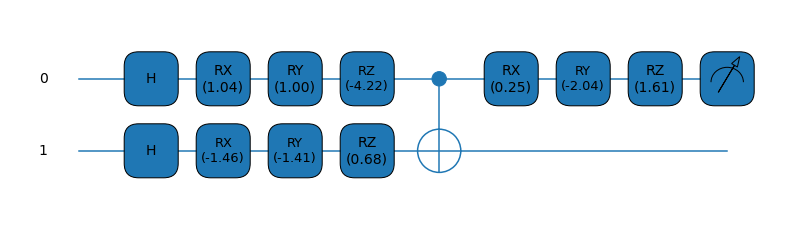

In [5]:
device = qml.device('qiskit.aer', wires=2, backend='qasm_simulator')
params = np.random.normal(0, np.pi/2, (2, 6))
params = Variable(torch.tensor(params), requires_grad=True)

@qml.qnode(device, interface='torch')
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0][0], wires=0)
    qml.RY(params[0][1], wires=0)
    qml.RZ(params[0][2], wires=0)
    qml.Hadamard(wires=1)
    qml.RX(params[1][0], wires=1)
    qml.RY(params[1][1], wires=1)
    qml.RZ(params[1][2], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(params[0][3], wires=0)
    qml.RY(params[0][4], wires=0)
    qml.RZ(params[0][5], wires=0)

    return qml.expval(qml.Hermitian(M, wires=[0]))


fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()


In [6]:
Paulis = Variable(torch.zeros([3, 2, 2], dtype=torch.complex128), requires_grad=False)
Paulis[0] = torch.tensor([[0, 1], [1, 0]])
Paulis[1] = torch.tensor([[0, -1j], [1j, 0]])
Paulis[2] = torch.tensor([[1, 0], [0, -1]])

def cost(params):
    L = 0
    for k in range(3):
        L += torch.abs(circuit(params, Paulis[k]) - target_vector[k])
        
    return L

In [7]:
opt = torch.optim.Adam([params], lr=0.1)
best_loss = 1*cost(params)
best_params = 1*params

In [8]:
for epoch in range(32):
    opt.zero_grad()
    loss = cost(params)
    print(epoch, loss)
    loss.backward()
    opt.step()

    if loss < best_loss:
        best_loss = 1*loss
        best_params = 1*params

0 tensor(1.4419, dtype=torch.float64, grad_fn=<AddBackward0>)
1 tensor(1.1314, dtype=torch.float64, grad_fn=<AddBackward0>)
2 tensor(0.8306, dtype=torch.float64, grad_fn=<AddBackward0>)
3 tensor(0.6367, dtype=torch.float64, grad_fn=<AddBackward0>)
4 tensor(0.3925, dtype=torch.float64, grad_fn=<AddBackward0>)
5 tensor(0.3066, dtype=torch.float64, grad_fn=<AddBackward0>)
6 tensor(0.2343, dtype=torch.float64, grad_fn=<AddBackward0>)
7 tensor(0.4081, dtype=torch.float64, grad_fn=<AddBackward0>)
8 tensor(0.2929, dtype=torch.float64, grad_fn=<AddBackward0>)
9 tensor(0.3560, dtype=torch.float64, grad_fn=<AddBackward0>)
10 tensor(0.2407, dtype=torch.float64, grad_fn=<AddBackward0>)
11 tensor(0.1958, dtype=torch.float64, grad_fn=<AddBackward0>)
12 tensor(0.3419, dtype=torch.float64, grad_fn=<AddBackward0>)
13 tensor(0.1876, dtype=torch.float64, grad_fn=<AddBackward0>)
14 tensor(0.3262, dtype=torch.float64, grad_fn=<AddBackward0>)
15 tensor(0.2774, dtype=torch.float64, grad_fn=<AddBackward0>)
16

In [9]:
print(best_loss)
print(best_params)

tensor(0.0962, dtype=torch.float64, grad_fn=<MulBackward0>)
tensor([[ 0.6367,  0.5564, -3.9196, -0.3260, -2.8495,  1.0134],
        [-1.4754, -1.7698,  1.4449, -0.5901, -0.0992, -1.1825]],
       dtype=torch.float64, grad_fn=<MulBackward0>)


In [10]:
X_exp = circuit(params, Paulis[0]).item()
Y_exp = circuit(params, Paulis[1]).item()
Z_exp = circuit(params, Paulis[2]).item()
print(X_exp, Y_exp, Z_exp)
print(target_vector.numpy())

0.193359375 0.017578125 0.626953125
[0.20828427+0.j 0.        -0.j 0.56760027+0.j]


In [12]:
rho = 0.5*(torch.eye(2) + X_exp*Paulis[0] + Y_exp*Paulis[1] + Z_exp*Paulis[2]).detach().numpy()
print(rho)

[[0.81347656+0.j         0.09667969-0.00878906j]
 [0.09667969+0.00878906j 0.18652344+0.j        ]]


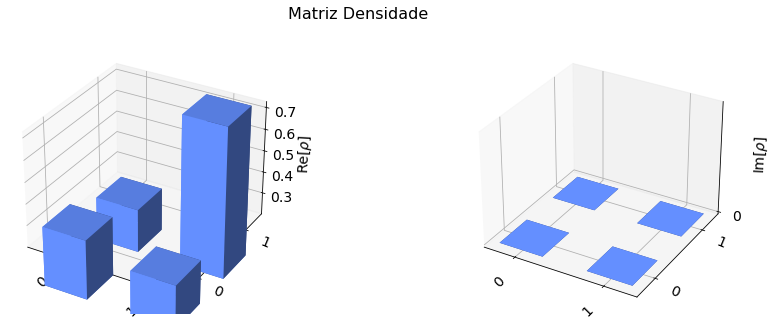

In [13]:
from qiskit.visualization import plot_state_city
plot_state_city(target_mixed, title='Matriz Densidade')